In [1]:
import xarray as xr
import modelskill

## Observations

In [2]:
o1 = modelskill.PointObservation('../tests/testdata/SW/HKNA_Hm0.dfs0', item=0, x=4.2420, y=52.6887, name="HKNA")
o2 = modelskill.PointObservation("../tests/testdata/SW/eur_Hm0.dfs0", item=0, x=3.2760, y=51.9990, name="EPL")
o3 = modelskill.TrackObservation("../tests/testdata/SW/Alti_c2_Dutch.dfs0", item=3, name="c2")

## MIKE ModelResult

In [3]:
mrMIKE = modelskill.ModelResult('../tests/testdata/SW/HKZN_local_2017_DutchCoast.dfsu', name='MIKE21SW', item=0)

## NetCDF ModelResult

In [4]:
fn = "../tests/testdata/SW/ERA5_DutchCoast.nc"
xr.open_dataset(fn)

<xarray.Dataset>
Dimensions:    (longitude: 20, latitude: 11, time: 67)
Coordinates:
  * longitude  (longitude) float32 -1.0 -0.5 0.0 0.5 1.0 ... 6.5 7.0 7.5 8.0 8.5
  * latitude   (latitude) float32 55.0 54.5 54.0 53.5 ... 51.5 51.0 50.5 50.0
  * time       (time) datetime64[ns] 2017-10-27 ... 2017-10-29T18:00:00
Data variables:
    mwd        (time, latitude, longitude) float32 ...
    mwp        (time, latitude, longitude) float32 ...
    mp2        (time, latitude, longitude) float32 ...
    pp1d       (time, latitude, longitude) float32 ...
    swh        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-07 12:25:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [5]:
mrERA5 = modelskill.ModelResult(fn, item="swh", name='ERA5')

In [6]:
mrERA5

<GridModelResult> 'ERA5'
- Item: swh

In [7]:
mrERA5.data  # mr contains the xr.Dataset

<xarray.Dataset>
Dimensions:  (x: 20, y: 11, time: 67)
Coordinates:
  * x        (x) float32 -1.0 -0.5 0.0 0.5 1.0 1.5 ... 6.0 6.5 7.0 7.5 8.0 8.5
  * y        (y) float32 55.0 54.5 54.0 53.5 53.0 52.5 52.0 51.5 51.0 50.5 50.0
  * time     (time) datetime64[ns] 2017-10-27 ... 2017-10-29T18:00:00
Data variables:
    mwd      (time, y, x) float32 ...
    mwp      (time, y, x) float32 ...
    mp2      (time, y, x) float32 ...
    pp1d     (time, y, x) float32 ...
    swh      (time, y, x) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-07 12:25:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

## Test extract from XArray

1) Extract point 
2) Extract track

In [8]:
mrERA5.extract(o1).data.head()

,ERA5
time,
2017-10-27 00:00:00,1.220337
2017-10-27 01:00:00,1.346573
2017-10-27 02:00:00,1.465747
2017-10-27 03:00:00,1.611757
2017-10-27 04:00:00,1.792901


In [9]:
mrERA5.extract(o3).data.head()

,x,y,ERA5
track,,,
2017-10-27 12:52:52.337,2.422854,51.253353,1.438809
2017-10-27 12:52:53.280,2.413789,51.310268,1.464191
2017-10-27 12:52:54.224,2.404711,51.367184,1.489200
2017-10-27 12:52:55.167,2.395619,51.424099,1.513833
2017-10-27 12:52:56.111,2.386516,51.481014,1.538092


## Multi-file ModelResult

Use mfdataset to load multiple files as a single ModelResult.

In [10]:
fn = "../tests/testdata/SW/CMEMS_DutchCoast_*.nc"
mrCMEMS = modelskill.ModelResult(fn, item="VHM0", name='CMEMS')
mrCMEMS

<GridModelResult> 'CMEMS'
- Item: VHM0

## Grib file ModelResult

In [11]:
fn = r"../tests/testdata/SW/NWW3_hs_201710.grib"

In [12]:
#mr3 = ModelResult(fn, name='WW3', engine='cfgrib') # not yet supported

## Connect multiple models and observations and extract

In [13]:
con = modelskill.Connector([o1,o2,o3], [mrERA5, mrCMEMS, mrMIKE])

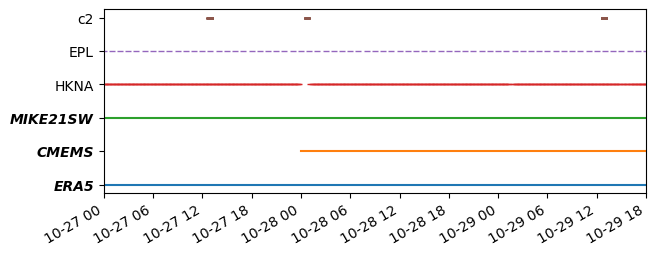

In [14]:
con.plot_temporal_coverage();

In [15]:
cc = con.extract()

## Analysis and plotting
Which model is better? 

In [16]:
sk = cc.skill()
sk.swaplevel().sort_index(level="observation").style()

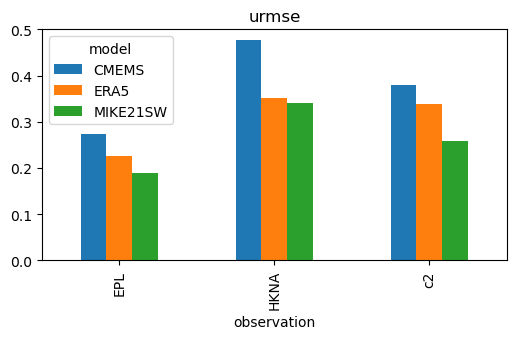

In [17]:
sk.plot_bar('urmse', figsize=(6,3));

In [18]:
cc.mean_skill().style()

,n,bias,rmse,urmse,mae,cc,si,r2
model,,,,,,,,
CMEMS,318,-0.493,0.627,0.376,0.530,0.909,0.103,0.368
ERA5,318,-0.442,0.539,0.305,0.457,0.936,0.084,0.460
MIKE21SW,318,0.006,0.344,0.263,0.277,0.947,0.072,0.774


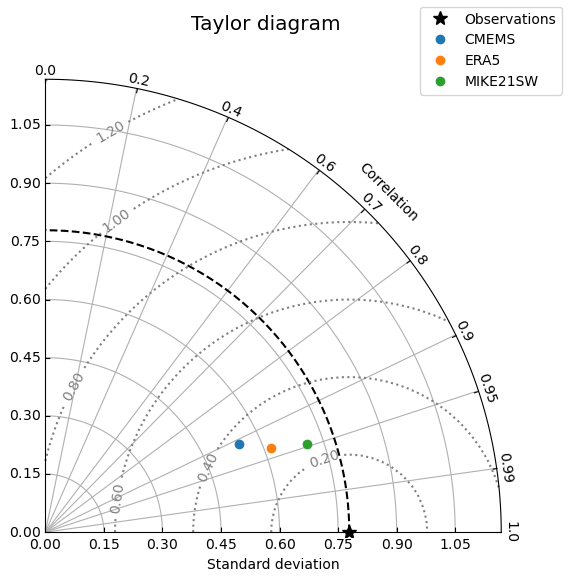

In [19]:
cc.taylor(figsize=6)